# Python Worksheet

## Setup

### Import packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Remove unrelated warning
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Download OASIS Dataset

We'll be downloading the data from `http://www.oasis-brains.org/pdf/oasis_longitudinal.csv`.

A full explanation of the data can be found in:

*Open Access Series of Imaging Studies (OASIS): Longitudinal MRI Data in Nondemented and Demented Older Adults. Marcus, DS, Fotenos, AF, Csernansky, JG, Morris, JC, Buckner, RL, 2010. Journal of Cognitive Neuroscience, 22, 2677-2684. doi: [10.1162/jocn.2009.21407](https://doi.org/10.1162/jocn.2009.21407)*

In [2]:
df = pd.read_csv('http://www.oasis-brains.org/pdf/oasis_longitudinal.csv')
# Print out the top 5 rows of the DataFrame
df.head(5)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


---
## Pre-processing the Data

### Dementia Status from CDR

We're told in the associated paper (linked above) that the CDR values correspond to the following levels of severity:
* 0 = No dementia
* 0.5 = Very mild Dementia
* 1 = Mild Dementia
* 2 = Moderate Dementia
* 3 = Severe Dementia

So let's derive this "Status" from the CDR values:

In [3]:
# Create a mapper from values to status/severity
cdr_mapper = {
    0: "No Dementia",
    0.5: "Very Mild Dementia",
    1: "Mild Dementia",
    2: "Moderate Dementia",
    3: "Severe Dementia",
}
# Create a column, mapping CDR values to this status
# Convert to categorical type, with severity as order
df["Status"] = pd.Categorical(
    df["CDR"].map(cdr_mapper),
    categories=cdr_mapper.values(),
    ordered=True
)

In [4]:
# Create colours for the different 'Status' categories
status_colours = {
    i:j for i,j in zip(cdr_mapper.values(), sns.color_palette("colorblind", 5))
}

Now we can look at this status, and how many records there are both overall, and at each of the visits (or time points).

In [5]:
# Let's look at how many records we have of each severity
df["Status"].value_counts()

No Dementia           206
Very Mild Dementia    123
Mild Dementia          41
Moderate Dementia       3
Severe Dementia         0
Name: Status, dtype: int64

In [6]:
# There are no records for "Severe Dementia", so we can tidy things up by removing this unused category
df["Status"] = df["Status"].cat.remove_unused_categories()

In [7]:
# How many of each status do we have at each visit?
df.groupby(["Visit", "Status"]).size()

Visit  Status            
1      No Dementia           85
       Very Mild Dementia    52
       Mild Dementia         13
       Moderate Dementia      0
2      No Dementia           73
       Very Mild Dementia    49
       Mild Dementia         19
       Moderate Dementia      3
3      No Dementia           34
       Very Mild Dementia    18
       Mild Dementia          6
       Moderate Dementia      0
4      No Dementia           10
       Very Mild Dementia     3
       Mild Dementia          2
       Moderate Dementia      0
5      No Dementia            4
       Very Mild Dementia     1
       Mild Dementia          1
       Moderate Dementia      0
dtype: int64

### Variable Types

In [8]:
df.dtypes

Subject ID      object
MRI ID          object
Group           object
Visit            int64
MR Delay         int64
M/F             object
Hand            object
Age              int64
EDUC             int64
SES            float64
MMSE           float64
CDR            float64
eTIV             int64
nWBV           float64
ASF            float64
Status        category
dtype: object

*Note: Further coercing of types (e.g. "Visit" is ordinal) is good practice, but the necessity depends on your analysis.*

### Convert Categorical Data

In [9]:
df["Sex"] = df["M/F"].map({
  "M": 0,
  "F": 1
})

### Visits & Baseline Data

In [10]:
df["Visit"].value_counts()

1    150
2    144
3     58
4     15
5      6
Name: Visit, dtype: int64

Filter for baseline data, and look at their status on arrival

In [11]:
df_baseline = df.loc[df["Visit"]==1]

In [12]:
df_baseline["Status"].value_counts()

No Dementia           85
Very Mild Dementia    52
Mild Dementia         13
Moderate Dementia      0
Name: Status, dtype: int64

---
## Data Exploration & Analysis

### Summarize Data

In [13]:
df.describe(include="all")

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,Status,Sex
count,373,373,373,373.000000,373.000000,373,373,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000,373,373.000000
unique,150,373,3,NaN,NaN,2,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,OAS2_0048,OAS2_0179_MR2,Nondemented,NaN,NaN,F,R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Dementia,NaN
freq,5,1,190,NaN,NaN,213,373,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206,NaN
mean,NaN,NaN,NaN,1.882038,595.104558,NaN,NaN,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461,NaN,0.571046
std,NaN,NaN,NaN,0.922843,635.485118,NaN,NaN,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092,NaN,0.495592
min,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000,NaN,0.000000
25%,NaN,NaN,NaN,1.000000,0.000000,NaN,NaN,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000,NaN,0.000000
50%,NaN,NaN,NaN,2.000000,552.000000,NaN,NaN,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000,NaN,1.000000
75%,NaN,NaN,NaN,2.000000,873.000000,NaN,NaN,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000,NaN,1.000000


### Missing Data

In [14]:
# Count amount of missing data
df.isna().sum(0)

Subject ID     0
MRI ID         0
Group          0
Visit          0
MR Delay       0
M/F            0
Hand           0
Age            0
EDUC           0
SES           19
MMSE           2
CDR            0
eTIV           0
nWBV           0
ASF            0
Status         0
Sex            0
dtype: int64

### Visualize Data

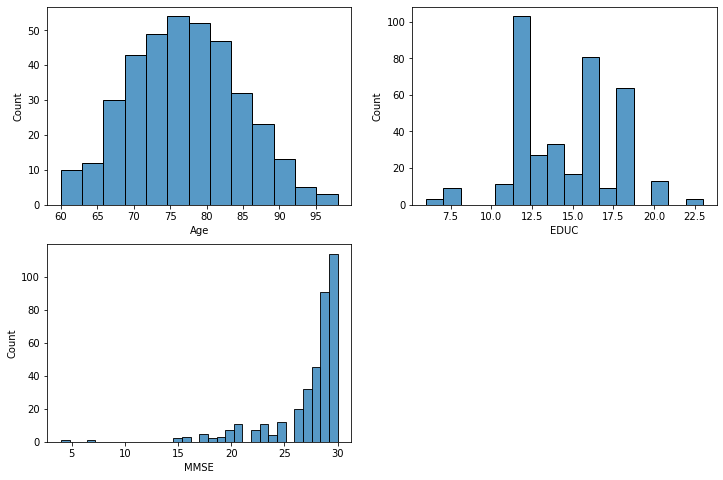

In [15]:
# Histograms
fig, axes = plt.subplots(2, 2, figsize=(12,8))

axes = axes.flatten()

for i, x_col in enumerate(["Age", "EDUC", "MMSE"]):
  sns.histplot(data=df, x=x_col, ax=axes[i])

fig.delaxes(axes[-1])

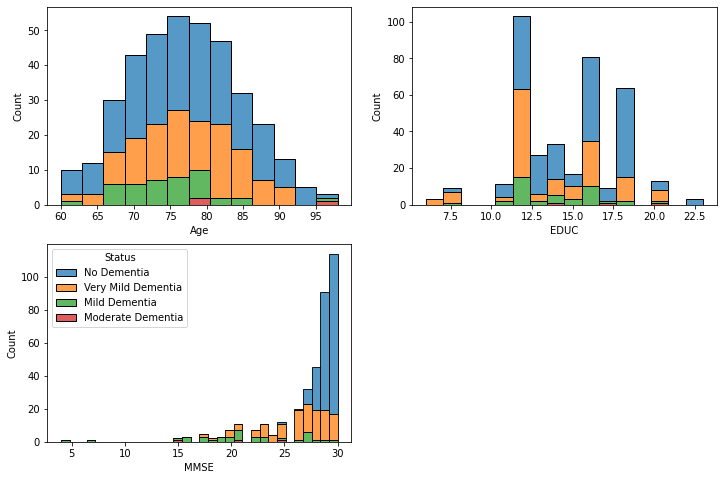

In [16]:
# Histograms stratified by dementia status
fig, axes = plt.subplots(2, 2, figsize=(12,8))
# Make it easier to loop over
axes = axes.flatten()
# Loop through the columns we want to plot a histogram for
for i, x_col in enumerate(["Age", "EDUC", "MMSE"]):
    sns.histplot(data=df, x=x_col, hue="Status", multiple="stack", ax=axes[i])
# Manually tidy up the legends
axes[0].get_legend().remove()
axes[1].get_legend().remove()
# Delete the extra axis (as we only plot 3 columns)
fig.delaxes(axes[-1])

### MMSE trajectories over time

We can visualize the MMSE trajectories of each subject over time to get an overall view of the cohort.

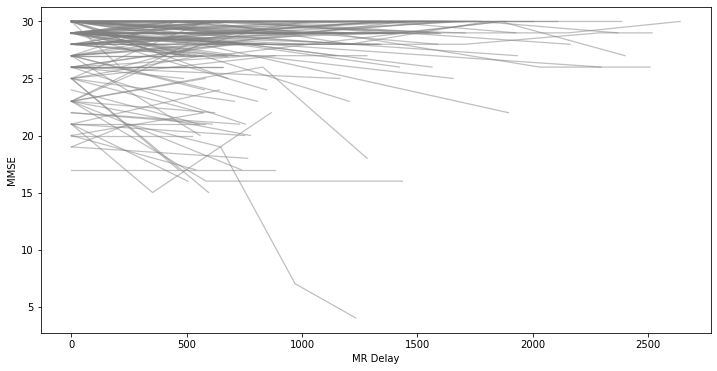

In [17]:
fig, ax = plt.subplots(figsize=(12,6))
for _, indiv_data in df.groupby("Subject ID"):
    ax = sns.lineplot(
        data=indiv_data,
        x="MR Delay",
        y="MMSE",
        ax=ax,
        color="grey",
        alpha=0.5,
        linewidth=1.25,
        linestyle="solid"
    )

We can make this graph a little more interesting by adding colour to each line, corresponding to the dementia status:

Text(0, 0.5, 'MMSE')

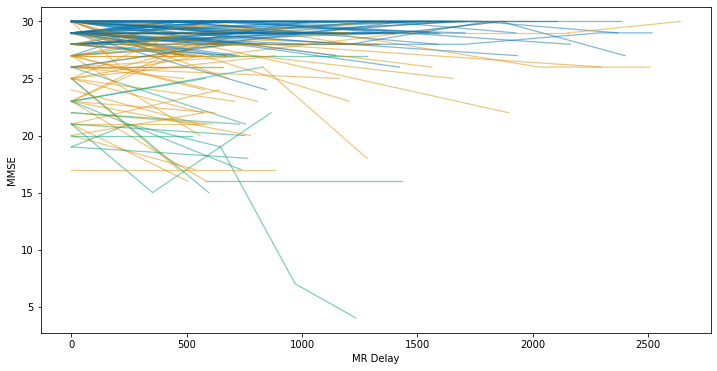

In [18]:
fig, ax = plt.subplots(figsize=(12,6))

# Loop over the individual subjects
for group, indiv_data in df.groupby(["Subject ID"]):
    # Extract xy data
    xy = indiv_data[["MR Delay", "MMSE"]].values
    # Plot normally for patients that do not change status
    if len(indiv_data["Status"].unique()) == 1:
      ax.plot(
          xy[:, 0],
          xy[:, 1],
          color=status_colours[indiv_data["Status"].unique()[0]],
          alpha=0.5,
          linewidth=1.25
      )
    else:
      # Duplicate points to construct line segments of different colours
      for i, (start, stop) in enumerate(zip(xy[:-1], xy[1:])):
        x, y = zip(start, stop)
        ax.plot(
            x, y,
            color=status_colours[indiv_data["Status"].iloc[i]],
            alpha=0.5,
            linewidth=1.25
        )
# Add the labels
ax.set_xlabel("MR Delay")
ax.set_ylabel("MMSE")

### Regression Analysis



#### Simple Linear Regression

Age vs MMSE: R-squared = 0.001
Sex vs MMSE: R-squared = 0.048
Yrs of Education vs MMSE: R-squared = 0.047
CDR vs MMSE: R-squared = 0.479


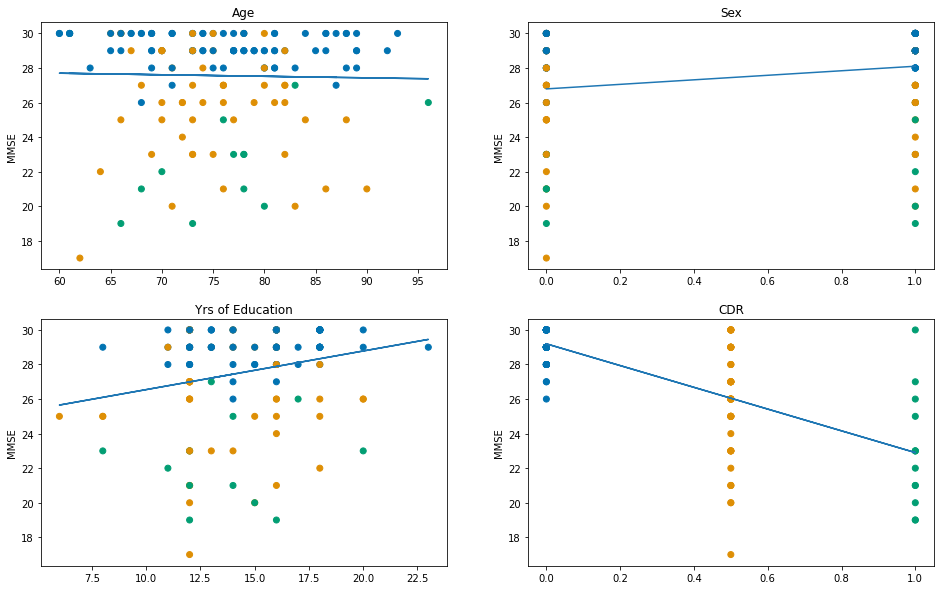

In [19]:
# Select the columns to iterate over
x_cols = ["Age", "Sex", "EDUC", "CDR"]
# Choose nicer names to display for each column
x_labels = ["Age", "Sex", "Yrs of Education", "CDR"]

fig, axes = plt.subplots(2,2, figsize=(16,10))

# Select the dependent variable
y = df_baseline["MMSE"].values
# Loop over the columns to fit each regression
for x_col, label, ax in zip(x_cols, x_labels, axes.flatten()):
    # Select x data
    x = df_baseline[x_col].values
    # Create the model
    model = sm.OLS(
        y, sm.add_constant(x)
    )
    # Fit the model
    res = model.fit()
    # Add a plot with regression line
    ax.plot(x, res.predict())
    # and the raw data
    ax.scatter(x, y, c=[status_colours[i] for i in df_baseline["Status"]])
    ax.set_title(label)
    ax.set_ylabel("MMSE")
    # Print the R^2
    print(f"{label} vs MMSE: R-squared = {res.rsquared:.3f}")

Then we can do the same again, but this time stratify by the dementia status (not including CDR this time):

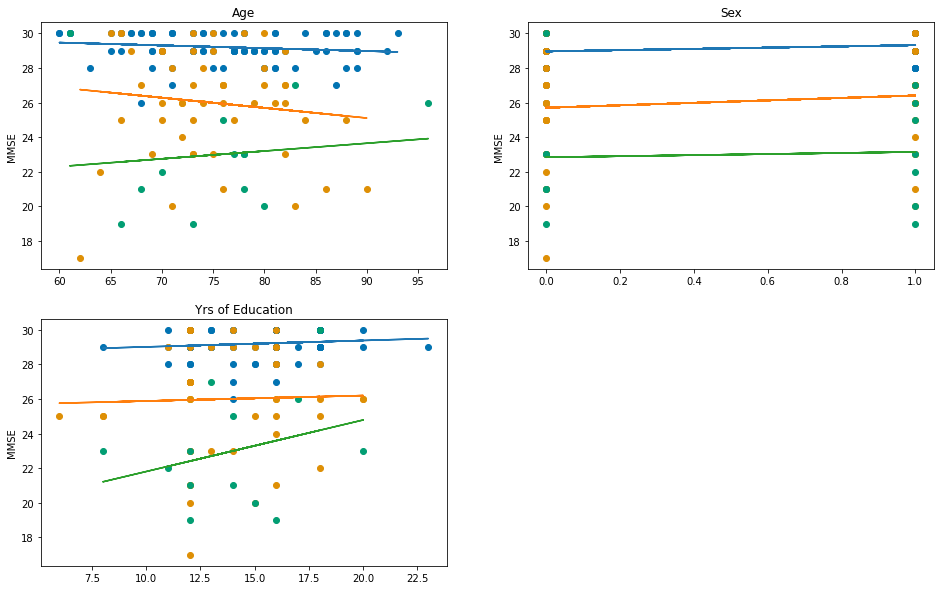

In [20]:
x_cols = ["Age", "Sex", "EDUC"]
x_labels = ["Age", "Sex", "Yrs of Education"]

fig, axes = plt.subplots(2,2, figsize=(16,10))
axes = axes.flatten()

for x_col, label, ax in zip(x_cols, x_labels, axes):
    for name, group_data in df_baseline.groupby("Status", observed=True):
        y = group_data["MMSE"]
        x = group_data[x_col]
        model = sm.OLS(
            y, sm.add_constant(x)
        )
        res = model.fit()
        
        ax.plot(x, res.predict())
        ax.scatter(x, y, color=status_colours[name])
    ax.set_title(label)
    ax.set_ylabel("MMSE")
# Delete the extra axis (as we only plot 3 columns)
fig.delaxes(axes[-1])

#### Multiple Linear Regression

We can create a regression model using age, sex, education, and CDR as our independent variables together:

In [21]:
# Create string for our independent variables
x = "Age + EDUC + Sex + C(CDR)"
# And select the dependent one
y = "MMSE"

mod = smf.ols(formula = f"{y} ~ {x}", data=df_baseline)
res = mod.fit()

# Print out a nice summary of results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   MMSE   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.475
Method:                 Least Squares   F-statistic:                     27.95
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           1.02e-19
Time:                        10:03:10   Log-Likelihood:                -324.67
No. Observations:                 150   AIC:                             661.3
Df Residuals:                     144   BIC:                             679.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        29.1743      2.140     13.632

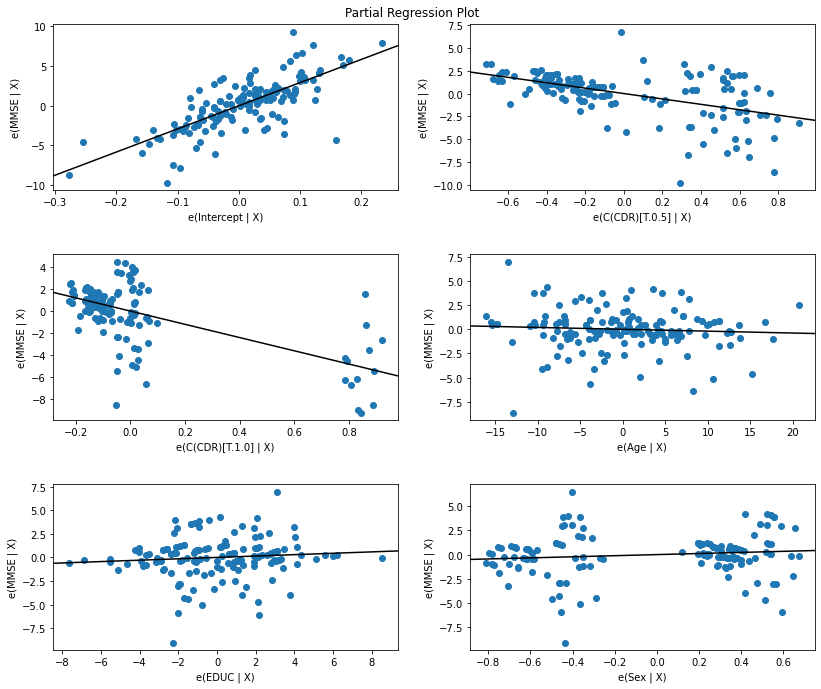

In [22]:
# Call statsmodel function for partial regression plot
fig = sm.graphics.plot_partregress_grid(res)
# Making the output nicer
fig.set_figheight(10)
fig.set_figwidth(12)
fig.tight_layout(pad=3)

### Results Table

Either using some of the analysis above, or through additional analysis of your own, create a summary results table below. What it includes is up to you, the overall aim is to get familiar with creating tables in markdown.

---
## Export to PDF

Now we can export this report to PDF, using the steps below.

**Note: You may need to change the paths and filenames depending your Google Drive structure, and what you have named this notebook.**

In [23]:
# Install what we need to create the PDF
%%capture
!apt update
!apt install texlive-xetex texlive-fonts-recommended texlive-generic-recommended

In [24]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [25]:
# Create a DEMON folder and move this notebook into it
%%bash
mkdir -p gdrive/MyDrive/DEMON/
if [ -f gdrive/MyDrive/Reproducible_Reporting.ipynb ]; then 
  mv gdrive/MyDrive/Reproducible_Reporting.ipynb gdrive/MyDrive/DEMON/Reproducible_Reporting.ipynb
fi
ls gdrive/MyDrive/DEMON/

Reproducible_Reporting.ipynb


In [26]:
# Change to the drive we created above
%cd gdrive/MyDrive/DEMON/

/content/gdrive/MyDrive/DEMON


In [27]:
!jupyter nbconvert Reproducible_Reporting.ipynb --to pdf --output ./Reproducible_Reporting.pdf

[NbConvertApp] Converting notebook Reproducible_Reporting.ipynb to pdf
[NbConvertApp] Writing 49953 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: [u'xelatex', u'./notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: [u'bibtex', u'./notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 59264 bytes to ./Reproducible_Reporting.pdf
